[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/QwenLM/Qwen2.5-VL)

# Zero-Shot Object Detection with Qwen2.5-VL

In Zero-Shot Object Detection (ZSD), the model can detect and classify unseen objects at test time without fine-tuning the object detection model on those specific classes. Instead, it relies on semantic information — such as:

*   Text descriptions
*   Class attributes
*   Word embeddings

**What is a Vision Language Model**
A vision language model is a smart computer programme that can look at/ understand pictures or videos (that's the vision part)

Read and write the text (that's the language part). Understand both together, just like a human can.

A VLM can see and read -  it processes images or videos like a vision model and interprets or describes them using text like a language model.

**What is a multimodal model ?**

A multimodal model is a smart computer program that can understand and work with more than one type of input like images or videos, text, audio

**Qwen2.5-VL**

Qwen2.5-VL is the vision-language model released in January 2025. It is a multimodal model capable of processing images, long videos, and text prompts. The model is available in four parameter sizes: 3B, 7B, 32B, and 72B.


###**Key Capabilities**
#### **Visual Recognition & Localization**

Recognizes objects, icons, graphics, charts, tables, handwritten text, and musical notation.

Outputs precise bounding boxes, points, and JSON-like structured descriptions.

### **📄 Document Parsing**

Expert at extracting structured data from forms, invoices, tables, diagrams, etc.

### **🛠️ Visual Agent**

Functions like a visual assistant—able to navigate interfaces, follow instructions, and reason across modalities without extensive fine-tuning.

## **🔬 Under the Hood**

Uses a Vision Transformer (ViT) trained from scratch with windowed attention and dynamic-resolution encoding, supporting native resolution image processing.

Employs dynamic frame sampling and multi-resolution rotary positional encoding (MRoPE) to handle both spatial and temporal variation in visual data.



![Qwen2.5-VL](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/qwen2.5vl_arc.jpeg)

##**Environment Setup**

### Configure your API keys

To benchmark Qwen2.5-VL, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page.
Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.


In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")


### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Jul  7 07:58:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Install Dependencies

Installs all required python libraries, including [`maestro`](https://github.com/roboflow/maestro) for Qwen2.5-VL

In [ ]:
!pip install -q "maestro[qwen_2_5_vl]==1.1.0rc2"

# Download Example Data

In [ ]:
!gdown "https://drive.google.com/uc?id=1Xa1EJO_Uwv-qr0i72VK2TaQALz7X0EP1&confirm=t"

!wget -q https://ultralytics.com/images/bus.jpg

Downloading...
From: https://drive.google.com/uc?id=1Xa1EJO_Uwv-qr0i72VK2TaQALz7X0EP1&confirm=t
To: /content/image.jpg
100% 214k/214k [00:00<00:00, 123MB/s]


## Load Qwen2.5-VL model

Loads the Qwen2.5-VL model (and its processor) from Hugging Face, preparing the model for inference.


The model supports a wide range of resolution inputs. By default, it uses the native resolution for input, but higher resolutions can enhance performance at the cost of more computation. Users can set the minimum and maximum number of pixels to achieve an optimal configuration for their needs, such as a token count range of 256-1280, to balance speed and memory usage.

In [ ]:
from maestro.trainer.models.qwen_2_5_vl.checkpoints import load_model, OptimizationStrategy

#min_pixels = 256 * 28 * 28
#max_pixels = 1280 * 28 * 28
MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-3B-Instruct"
MIN_PIXELS = 512 * 28 * 28
MAX_PIXELS = 2048 * 28 * 28

processor, model = load_model(
    model_id_or_path=MODEL_ID_OR_PATH,
    optimization_strategy=OptimizationStrategy.NONE,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

## Qwen2.5-VL inference and visualization

### Define helper functions

Creates a function to run text prompts against the Qwen2.5-VL model and parse the results.

In [ ]:
from PIL import Image
from typing import Optional, Tuple, Union

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info

def run_qwen_2_5_vl_inference(
    model,
    processor,
    image: Image.Image,
    prompt: str,
    system_message: Optional[str] = None,
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    conversation = format_conversation(image=image, prefix=prompt, system_message=system_message)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )

    input_h = inputs['image_grid_thw'][0][1] * 14
    input_w = inputs['image_grid_thw'][0][2] * 14

    response = predict_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )[0]

    return response, (input_w, input_h)

### Detect "each person"

Prompts the model to detect all persons in the image, outputs JSON coordinates, and visualizes detections.

In [ ]:
from PIL import Image

IMAGE_PATH = "/content/bus.jpg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of each person and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [670, 398, 812, 888], "label": "person"},
	{"bbox_2d": [225, 411, 345, 868], "label": "person"},
	{"bbox_2d": [51, 403, 245, 912], "label": "person"}
]
```


In [ ]:
import json
from PIL import Image, ImageDraw, ImageFont

def clean_json_block(text):
    # Removes triple backticks and trims whitespace
    return text.replace("```json", "").replace("```", "").strip()

def draw_boxes(image_path, response, save_path="output.jpg"):
    if isinstance(response, str):
        response = clean_json_block(response)
        response = json.loads(response)

    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    #font = ImageFont.load_default()
    font = ImageFont.truetype("Roboto-Bold.ttf", size=24)
    for obj in response:
        x1, y1, x2, y2 = obj["bbox_2d"]
        label = obj["label"]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 30), label, fill="white", font=font)

    image.save(save_path)
    #image.show()



In [ ]:
draw_boxes("/content/bus.jpg", response)

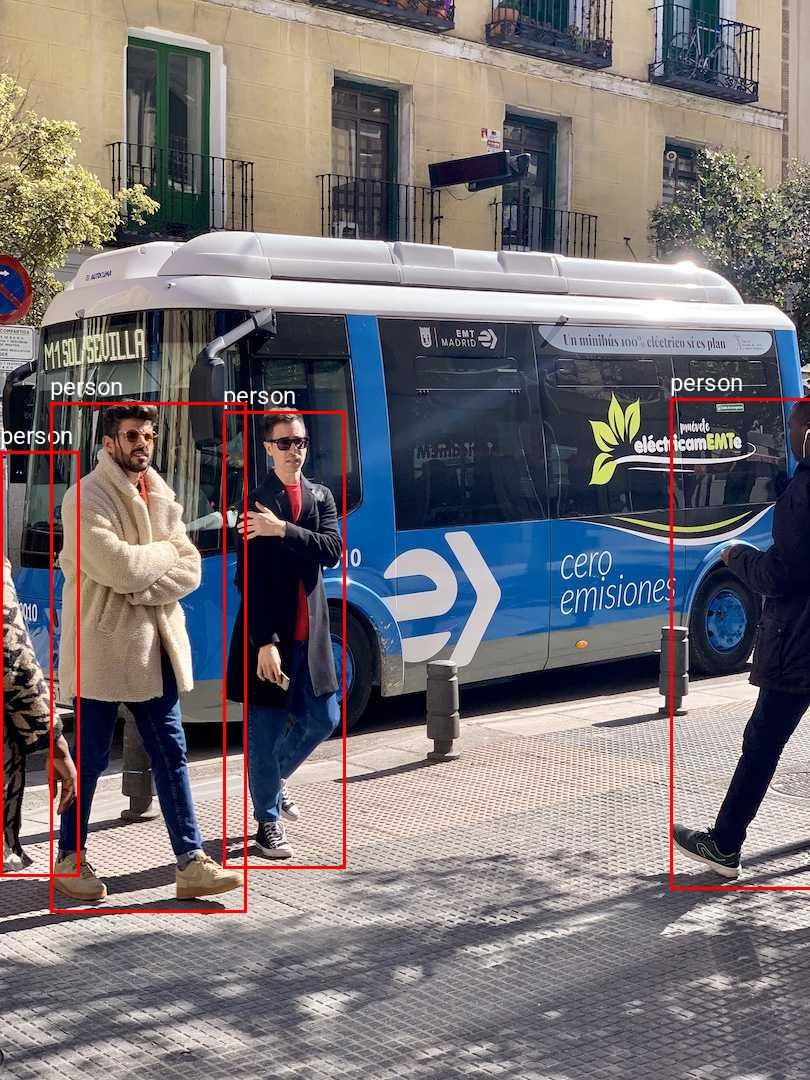

In [ ]:
from IPython.display import Image
Image("/content/output.jpg")

### Detect multiple objects

Prompts the model to find several objects (person, bus, shoes.) in the image, then visualizes the results.

In [ ]:
from PIL import Image

IMAGE_PATH = "/content/bus.jpg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of person, bus, shoes and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [670, 398, 812, 885], "label": "person"},
	{"bbox_2d": [224, 411, 345, 868], "label": "person"},
	{"bbox_2d": [50, 403, 246, 912], "label": "person"},
	{"bbox_2d": [0, 451, 79, 878], "label": "person"},
	{"bbox_2d": [3, 233, 806, 746], "label": "bus"},
	{"bbox_2d": [51, 858, 107, 912], "label": "shoes"},
	{"bbox_2d": [254, 828, 293, 868], "label": "shoes"},
	{"bbox_2d": [281, 799, 302, 828], "label": "shoes"},
	{"bbox_2d": [670, 831, 744, 888], "label": "shoes"}
]
```


In [ ]:
draw_boxes("/content/bus.jpg", response)

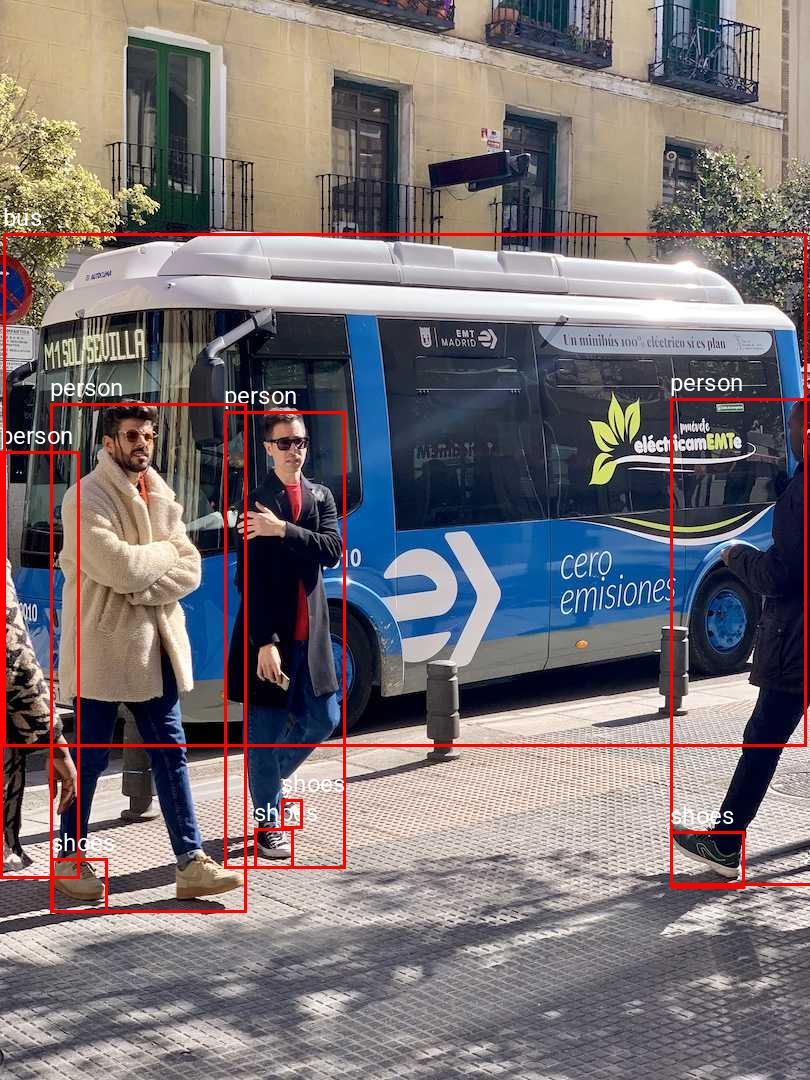

In [ ]:
from IPython.display import Image

Image("/content/output.jpg")

### Detect multiple objects

Prompts the model to find several objects (person, bus, shoes, bicycle, trafficlights, handbag, bagpack.) in the image, then visualizes the results.

In [ ]:
from PIL import Image

IMAGE_PATH = "/content/image.jpg"
SYSTEM_MESSAGE = None
PROMPT = "Outline the position of bag, bus, traffic lights, bicycle, hand bag, bag pack, shoes, helmet and output all the coordinates in JSON format."

image = Image.open(IMAGE_PATH)
resolution_wh = image.size
response, input_wh = run_qwen_2_5_vl_inference(
    model=model,
    processor=processor,
    image=image,
    prompt=PROMPT,
    system_message=SYSTEM_MESSAGE
)

print(response)

```json
[
	{"bbox_2d": [560, 478, 603, 564], "label": "bag"},
	{"bbox_2d": [301, 176, 784, 479], "label": "bus"},
	{"bbox_2d": [700, 89, 833, 279], "label": "traffic lights"},
	{"bbox_2d": [838, 112, 882, 284], "label": "traffic lights"},
	{"bbox_2d": [394, 599, 511, 672], "label": "bicycle"},
	{"bbox_2d": [476, 430, 558, 571], "label": "hand bag"},
	{"bbox_2d": [665, 455, 719, 544], "label": "bag pack"},
	{"bbox_2d": [0, 448, 66, 672], "label": "bag pack"},
	{"bbox_2d": [773, 654, 833, 672], "label": "shoes"},
	{"bbox_2d": [858, 618, 894, 644], "label": "shoes"},
	{"bbox_2d": [833, 628, 860, 650], "label": "shoes"},
	{"bbox_2d": [281, 313, 366, 388], "label": "helmet"}
]
```


In [ ]:
draw_boxes("/content/image.jpg", response)

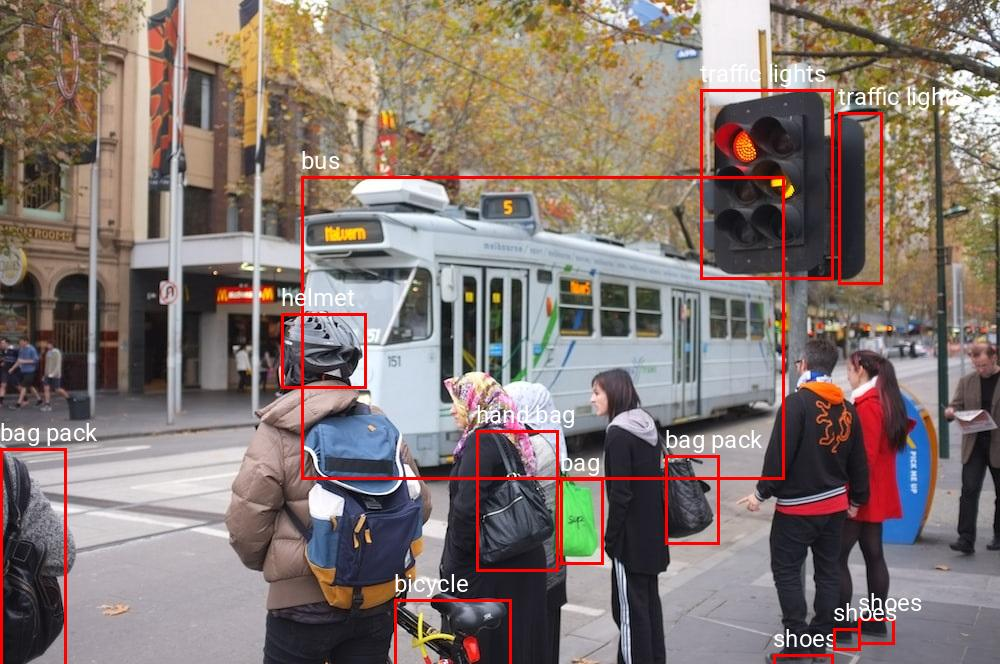

In [ ]:
from IPython.display import Image

Image("/content/output.jpg")